In [120]:
import cantera as ct
import numpy as np
from scipy.optimize import fsolve

In [127]:
gas = ct.Solution("gri30.xml")
xair = np.zeros(gas.n_species)
xair[gas.species_index("N2")]  = 0.78084 + 0.00934 # (+argon)
xair[gas.species_index("O2")]  = 0.209476
xair[gas.species_index("CO2")] = 0.000314
gas.X = xair
xair = gas.X

P = 1E5
RH = 0.45
Psat = 2671  # (at 22 oC, interpolated from Cengel thermo book)
Phi = 0.9

xh2o = RH*Psat/P
xair = xair * (1-xh2o)
xair[gas.species_index("H2O")] = xh2o
gas.X = xair

Mair = gas.mean_molecular_weight

MC2H4 = gas.molecular_weights[gas.species_index("C2H4")] 
Zst = MC2H4/(MC2H4 + 3*Mair/xair[gas.species_index("O2")])

Zpilot = Zst*Phi/(Zst*Phi + 1 - Zst)
Zfuel  = 1
Zair   = 0
print("Zpilot = %g" %Zpilot)
print("Zfuel  = %g" %Zfuel)
print("Zair   = %g\n" %Zair)
print("X_air:")
print("\tO2  = %g" %(xair[gas.species_index("O2")]))
print("\tN2  = %g" %(xair[gas.species_index("N2")]))
print("\tH2O = %g" %(xair[gas.species_index("H2O")]))
print("\tCO2 = %g" %(xair[gas.species_index("CO2")]+2.65E-7))
print("X_fuel:")
print("\tC2H4= 1.0")


Zpilot = 0.0571752
Zfuel  = 1
Zair   = 0

X_air:
	O2  = 0.206964
	N2  = 0.780706
	H2O = 0.0120195
	CO2 = 0.0003105
X_fuel:
	C2H4= 1.0


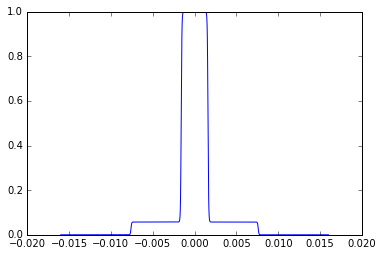

In [122]:
r_f = 0.0032/2
r_p = 0.0152/2

r_dom = r_f*10
dth   = r_f/10
x = np.linspace(-r_dom,r_dom, 1000)

p1 = 0.5*(1.0+np.tanh(2.0/dth*(x+r_f))) * 0.5*(1+np.tanh(2/dth*(r_f-x)))
p1 = p1*(1-Zpilot)
p2 = 0.5*(1.0+np.tanh(2.0/dth*(x+r_p))) * 0.5*(1+np.tanh(2/dth*(r_p-x)))
p2 = p2*(Zpilot)
Zprof = p1+p2
plt.plot(x,Zprof)


In [123]:
U_f = 54.7
U_a = 0.635
mdot_p = 10.63/60/1000

#-------- Get pilot velocity
# Mass flow rate is 10.63 g/min
# Use mdot = rho*A*V to get V.
# Get rho from products of complete combustion, since that is what the code will use.

gas.X = xair
y = gas.Y
y[gas.species_index("C2H4")] = Zpilot/(1-Zpilot)     # mass fuel for 1 kg of air
gas.Y = y
Xpilot = gas.X

gas.TPY = 295, P, y
hR = gas.enthalpy_mass

xpcc = np.zeros(gas.n_species)
xpcc[gas.species_index("N2")]   = Xpilot[gas.species_index("N2")]
xpcc[gas.species_index("C2H4")] = 0
xpcc[gas.species_index("H2O")]  = Xpilot[gas.species_index("H2O")] + \
                                  2*Xpilot[gas.species_index("C2H4")]
xpcc[gas.species_index("CO2")]  = Xpilot[gas.species_index("CO2")] + \
                                  2*Xpilot[gas.species_index("C2H4")]
xpcc[gas.species_index("O2")]   = Xpilot[gas.species_index("O2")] - \
                                  3*Xpilot[gas.species_index("C2H4")]

def F(Tp) :
    gas.TPX = Tp, P, xpcc
    return gas.enthalpy_mass - hR

Tp = fsolve(F, 2000)
print("Tpcc = %g K" %Tp)

gas.TPX = Tp, P, xpcc
rho_pilot = gas.density

Ap = np.pi * (r_p**2 - r_f**2)

U_p = mdot_p / rho_pilot / Ap
print("U_p = %g m/s" %U_p)

Tpcc = 2357.25 K
U_p = 6.98062 m/s


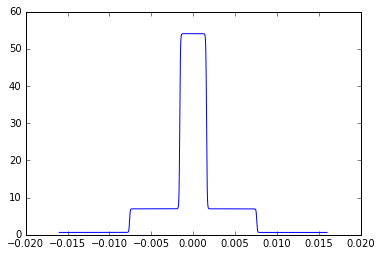

In [124]:
p1 = 0.5*(1.0+np.tanh(2.0/dth*(x+r_f))) * 0.5*(1+np.tanh(2/dth*(r_f-x)))
p1 = p1*(U_f-U_p-U_a)
p2 = 0.5*(1.0+np.tanh(2.0/dth*(x+r_p))) * 0.5*(1+np.tanh(2/dth*(r_p-x)))
p2 = p2*(U_p-U_a)
Uprof = p1+p2 + U_a
plt.plot(x,Uprof)